# CS441 Final Project: Sudoku Solvers
## Backtracking vs CSP + Heuristics
### Group: Abdel Elkasaby, Neha Marlady, Jordan Nakamura, Gil Tighe, Arlyss West

# Imports

In [1]:
import numpy as np
import time

# Converting CSV to numpy arrays

In [2]:
def load_sudoku_csv(path, limit=None):
    lines = open(path, 'r').read().splitlines()[1:]
    if limit is not None:
        lines = lines[:limit]
    N = len(lines)
    quizzes = np.zeros((N, 9, 9), np.int32)
    solutions = np.zeros((N, 9, 9), np.int32)
    for i, line in enumerate(lines):
        quiz, sol = line.split(",")
        for j in range(81):
            quizzes[i, j//9, j%9] = int(quiz[j])
            solutions[i, j//9, j%9] = int(sol[j])
    return quizzes, solutions

quizzes, solutions = load_sudoku_csv("sudoku.csv", limit=100)


# Backtracking Utilities

In [3]:
def find_empty(board):
    for r in range(9):
        for c in range(9):
            if board[r,c] == 0:
                return r, c
    return None

def is_valid(board, row, col, val):
    if val in board[row,:]:
        return False
    if val in board[:,col]:
        return False
    br = (row//3)*3
    bc = (col//3)*3
    if val in board[br:br+3, bc:bc+3]:
        return False
    return True

# Backtracking Solver

In [4]:
def solve_backtracking(board, count):
    pos = find_empty(board)
    if pos is None:
        return True
    r, c = pos
    for val in range(1,10):
        if is_valid(board, r, c, val):
            board[r,c] = val
            count[0] += 1
            if solve_backtracking(board, count):
                return True
            board[r,c] = 0
    return False

def run_backtracking(puzzle):
    board = puzzle.copy()
    count = [0]
    t0 = time.time()
    ok = solve_backtracking(board, count)
    t1 = time.time()
    return ok, count[0], t1-t0, board

# CSP Initialization

In [5]:
def init_domains(board):
    domains = {}
    for r in range(9):
        for c in range(9):
            if board[r,c] == 0:
                domains[(r,c)] = set(range(1,10))
            else:
                domains[(r,c)] = {board[r,c]}
    return domains

def neighbors_dict():
    n = {}
    for r in range(9):
        for c in range(9):
            s = set()
            for k in range(9):
                if k!=c:
                    s.add((r,k))
                if k!=r:
                    s.add((k,c))
            br = (r//3)*3
            bc = (c//3)*3
            for rr in range(br, br+3):
                for cc in range(bc, bc+3):
                    if rr!=r or cc!=c:
                        s.add((rr,cc))
            n[(r,c)] = s
    return n

neighbors = neighbors_dict()

# AC-3 Constraint Propagation

In [6]:
from collections import deque

def revise(domains, xi, xj):
    removed = False
    to_remove = set()
    for v in domains[xi]:
        ok = False
        for w in domains[xj]:
            if v!=w:
                ok = True
                break
        if not ok:
            to_remove.add(v)
    if to_remove:
        domains[xi] = domains[xi] - to_remove
        removed = True
    return removed

def ac3(domains):
    q = deque()
    for xi in domains:
        for xj in neighbors[xi]:
            q.append((xi,xj))
    while q:
        xi,xj = q.popleft()
        if revise(domains, xi, xj):
            if len(domains[xi]) == 0:
                return False
            for xk in neighbors[xi]:
                if xk!=xj:
                    q.append((xk,xi))
    return True


# CSP MRV Selection

In [7]:
def select_var(board, domains):
    best = None
    best_size = 10
    for r in range(9):
        for c in range(9):
            if board[r,c] == 0:
                d = len(domains[(r,c)])
                if d < best_size:
                    best_size = d
                    best = (r,c)
    return best

# Forward Checking

In [8]:
def forward_check(domains, pos, val):
    r,c = pos
    for nr,nc in neighbors[pos]:
        if val in domains[(nr,nc)]:
            if len(domains[(nr,nc)]) == 1:
                return False
    return True

# CSP Recursive Solver


In [9]:
def solve_csp(board, domains, count):
    pos = select_var(board, domains)
    if pos is None:
        return True
    r,c = pos
    list_vals = list(domains[(r,c)])
    for val in list_vals:
        if forward_check(domains, pos, val):
            saved = {}
            for k in domains:
                saved[k] = set(domains[k])
            board[r,c] = val
            domains[(r,c)] = {val}
            ac3(domains)
            count[0] += 1
            if solve_csp(board, domains, count):
                return True
            board[r,c] = 0
            for k in saved:
                domains[k] = saved[k]
    return False

def run_csp(puzzle):
    board = puzzle.copy()
    domains = init_domains(board)
    ac3(domains)
    count = [0]
    t0 = time.time()
    ok = solve_csp(board, domains, count)
    t1 = time.time()
    return ok, count[0], t1-t0, board


# Evaluation Functions


In [10]:
def check_correct(a, b):
    return np.array_equal(a, b)

def evaluate_solver(fn, quizzes, solutions):
    times = []
    assigns = []
    correct = 0
    for i in range(len(quizzes)):
        ok, a, t, sol = fn(quizzes[i])
        times.append(t)
        assigns.append(a)
        if check_correct(sol, solutions[i]):
            correct += 1
    return np.mean(times), np.mean(assigns), correct / len(quizzes)


# Backtracking Results


In [11]:
bt_time, bt_assign, bt_acc = evaluate_solver(run_backtracking, quizzes, solutions)
bt_time, bt_assign, bt_acc


(np.float64(0.02121074914932251), np.float64(137.87), 1.0)

# CSP Results


In [12]:
csp_time, csp_assign, csp_acc = evaluate_solver(run_csp, quizzes, solutions)
csp_time, csp_assign, csp_acc


(np.float64(0.06335513830184937), np.float64(47.23), 1.0)

# Example Solve Backtracking


In [13]:
ok, a, t, sol = run_backtracking(quizzes[0])
sol


array([[8, 6, 4, 3, 7, 1, 2, 5, 9],
       [3, 2, 5, 8, 4, 9, 7, 6, 1],
       [9, 7, 1, 2, 6, 5, 8, 4, 3],
       [4, 3, 6, 1, 9, 2, 5, 8, 7],
       [1, 9, 8, 6, 5, 7, 4, 3, 2],
       [2, 5, 7, 4, 8, 3, 9, 1, 6],
       [6, 8, 9, 7, 3, 4, 1, 2, 5],
       [7, 1, 3, 5, 2, 8, 6, 9, 4],
       [5, 4, 2, 9, 1, 6, 3, 7, 8]], dtype=int32)

# Example Solve CSP


In [14]:
ok, a, t, sol = run_csp(quizzes[0])
sol


array([[8, 6, 4, 3, 7, 1, 2, 5, 9],
       [3, 2, 5, 8, 4, 9, 7, 6, 1],
       [9, 7, 1, 2, 6, 5, 8, 4, 3],
       [4, 3, 6, 1, 9, 2, 5, 8, 7],
       [1, 9, 8, 6, 5, 7, 4, 3, 2],
       [2, 5, 7, 4, 8, 3, 9, 1, 6],
       [6, 8, 9, 7, 3, 4, 1, 2, 5],
       [7, 1, 3, 5, 2, 8, 6, 9, 4],
       [5, 4, 2, 9, 1, 6, 3, 7, 8]], dtype=int32)

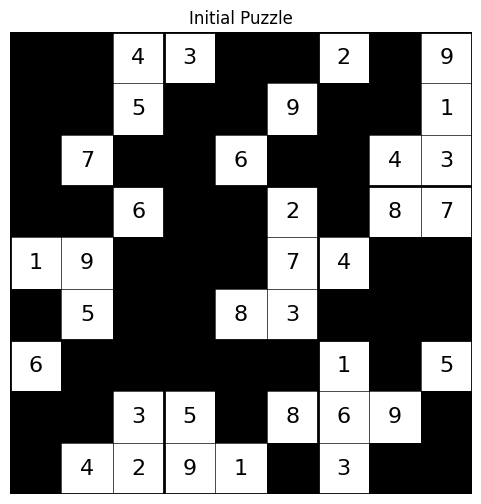

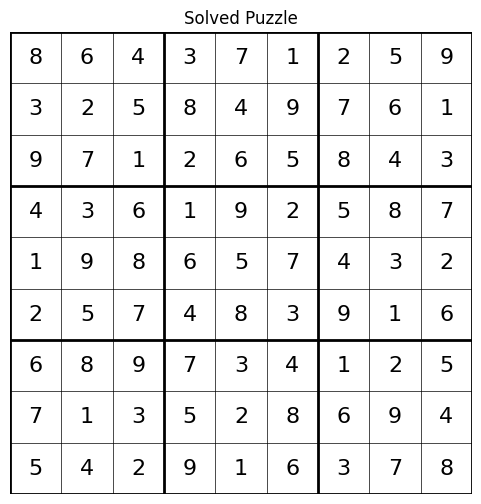

In [20]:
# Visualize first Sudoku puzzle
initial_board = quizzes[0]
plot_sudoku(initial_board, "Initial Puzzle")

# Visualize the solution (if you solved quizzes[0] into sol)
plot_sudoku(sol, "Solved Puzzle")


# Summary Table


In [15]:
np.array([
    ["Backtracking", bt_time, bt_assign, bt_acc],
    ["CSP", csp_time, csp_assign, csp_acc]
])

array([['Backtracking', '0.02121074914932251', '137.87', '1.0'],
       ['CSP', '0.06335513830184937', '47.23', '1.0']], dtype='<U32')

# Solving Time Comparison

Text(0.5, 1.0, 'Solving Time Comparison: Backtracking vs CSP')

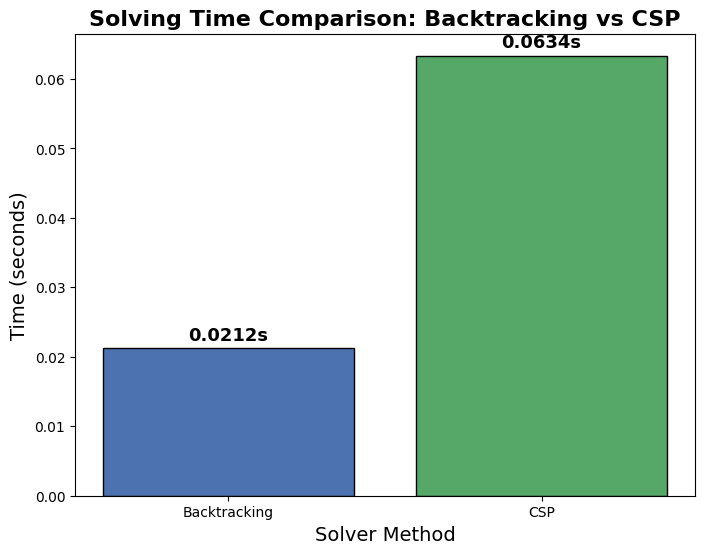

In [28]:
import matplotlib.pyplot as plt
import numpy as np

result = np.array([
    ["Backtracking", bt_time, bt_assign, bt_acc],
    ["CSP", csp_time, csp_assign, csp_acc]
])


methods = result[:, 0]
times = result[:, 1].astype(float)

plt.figure(figsize=(8,6))
bars = plt.bar(methods, times, color=["#4C72B0", "#55A868"], edgecolor='black')

# Add labels on bars
for bar in bars:
    y = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        y + (max(times) * 0.01),       # fixes clipping
        f"{y:.4f}s",
        ha='center', va='bottom',
        fontsize=13, fontweight='bold'
    )

plt.ylabel("Time (seconds)", fontsize=14)
plt.xlabel("Solver Method", fontsize=14)
plt.title("Solving Time Comparison: Backtracking vs CSP", fontsize=16, fontweight='bold')


# Assignment Comparision

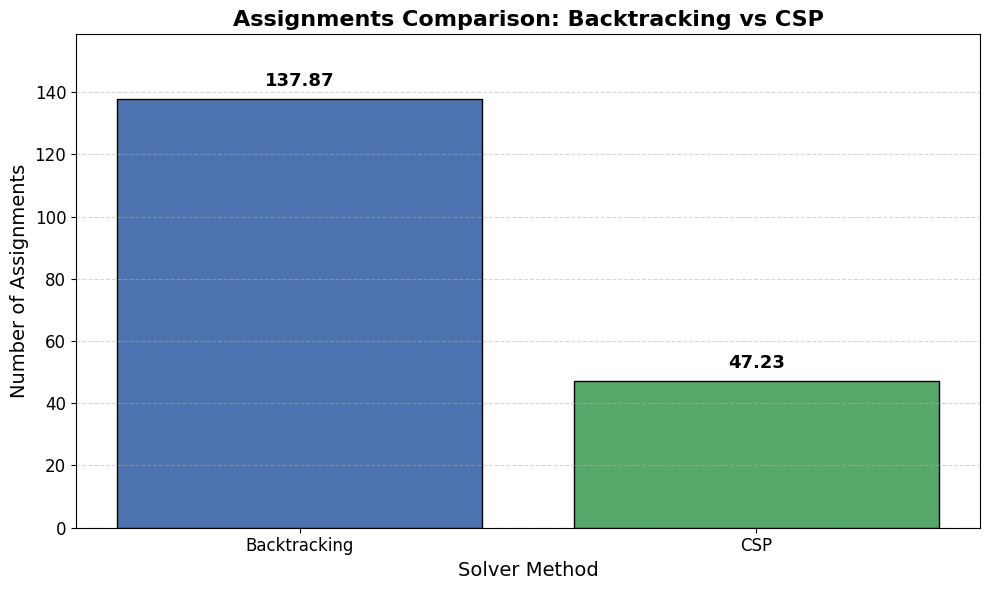

In [30]:

methods = result[:, 0]
assignments = result[:, 2].astype(float)

plt.figure(figsize=(10,6))
bars = plt.bar(methods, assignments, color=["#4C72B0", "#55A868"], edgecolor='black')

# Add labels on bars
for bar in bars:
    y = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        y + max(assignments) * 0.02,
        f"{y:.2f}",
        ha='center', va='bottom',
        fontsize=13, fontweight='bold'
    )

plt.ylabel("Number of Assignments", fontsize=14)
plt.xlabel("Solver Method", fontsize=14)
plt.title("Assignments Comparison: Backtracking vs CSP", fontsize=16, fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, max(assignments) * 1.15)

plt.tight_layout()
plt.show()


# Accuracy Comparison

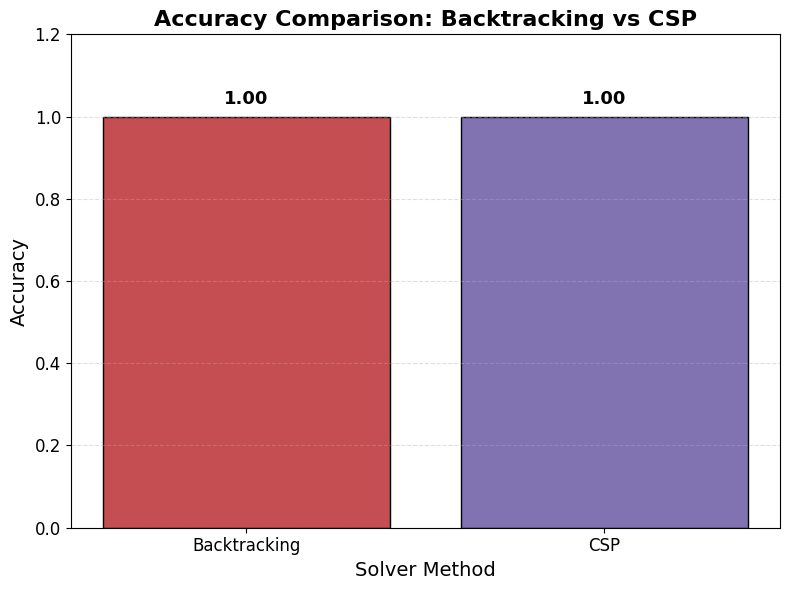

In [31]:
accuracy = result[:, 3].astype(float)

plt.figure(figsize=(8,6))
bars = plt.bar(methods, accuracy, color=["#C44E52", "#8172B2"], edgecolor='black')

# Add labels above bars
for bar in bars:
    y = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        y + 0.02,
        f"{y:.2f}",
        ha='center', va='bottom',
        fontsize=13, fontweight='bold'
    )

plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Solver Method", fontsize=14)
plt.title("Accuracy Comparison: Backtracking vs CSP", fontsize=16, fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1.2)

plt.tight_layout()
plt.show()
